## Imports


In [27]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from matplotlib.path import Path 
from io import BytesIO

%matplotlib inline 

Load data from the json source file in variables.
This loads the file 'trip_final.json' that is available from the Montréal Open Data Portal at: 
http://donnees.ville.montreal.qc.ca/dataset/mtl-trajet
The website also contains an explaination of the methodology and the contents of this and related data-sets.
A direct link to the json zip file is at the url below:
http://depot.ville.montreal.qc.ca/mtl-trajet-2016/trip_final_2016_json.zip

For this notebook, you will also need to have the borough shapefiles, which can be dowloaded from:
http://donnees.ville.montreal.qc.ca/dataset/polygones-arrondissements

The .py file run in the cell below loads the data from the LIMADMIN.json file

In [12]:
%run "load_trip_data.py"

## Variable reference - what you should know.

Because the loading of the files is happening in the 'load_trip_data.py' python file, it's worth explaining some of the variables here that will be used throughout the notebook.

    - trip_final: a library that is created by loading the json file into Python. 
    - coords_if: a 293,xxx- row by 4-column array that contains the initial [0][1] and final [2][3] coordinates for each entry, made from 'trip_final' to be more immediately accessible
    - burrShapes: contains the coordinates from the shapefiles for the different boroughs of Montréal. Coordinates are in Latitude - Longitude (Thankfully)
    - numIds: integer that reflects the number of trajectories in the original data set, used to iterate through trip_final
    - ids: A vector of length numIds that contains the unique ID number associated with each recorded trajectory. This is used for comparing subsets and applying selection criteria.

## Process the data
This section contains the operations to arrange the data appropriately to be visualized in the next section.

Create a Path object that hold the shapes of the individual burroughs

In [15]:
allPaths=Path(np.empty((1,2)))
currBurr=0
for currBurr in range(0,34):
    currBurr_array=[]
    currBurr_array=np.asarray(burrShapes['features'][currBurr]['geometry']['coordinates'][0][0])
    currBurrPath = Path(currBurr_array)
    allPaths = Path.make_compound_path(allPaths,currBurrPath)

Create 'masks' - boolean lists of rows that match our criteria, that will be applied to the ID list to filter.

In [16]:
# Find all the ids for trajectories that begin outside of the collection of all boroughs (on the island)
mask1 = allPaths.contains_points(coords_if[:,:2])

# Invert the selection to instead have the rows for all trajectories starting outside the collection of boroughs
mask1_inv=np.invert(mask1.astype(bool))

# Use the 'mask' to create a list of the IDs that start off the island
startIds=ids[mask1_inv.astype(bool)]

# Use the same method above to generate a list of IDs for trajectories ending on the island.
mask2 = allPaths.contains_points(coords_if[:,2:])
endIds=ids[mask2]

# Find the overlap of those two sets of IDs to find keep only the trajectories starting off and ending on the island.
mask3=np.isin(startIds, endIds, assume_unique=True)
sharedIDs=startIds[mask3]

# Initialize empty arrays to hold the initial and final points
startPts=np.empty((numIds,2))
endPts=np.empty((numIds,2))

# Iterate through the dictionary and store the start and endpoints to seperate numpy arrays.
iS=0
for nTraj in range(0,numIds):
    tempID=trip_final["features"][nTraj]["properties"]["id_trip"]
    if sum(np.isin(sharedIDs,tempID))>0:
        if trip_final["features"][nTraj]["geometry"] is not None: 
            tempArray=[]
            tempArray=np.asarray(trip_final["features"][nTraj]["geometry"]["coordinates"][0][:]) # Load data as array instead of as a list.
            startPts[iS,0:2] = tempArray[0,0:2]
            endPts[iS,0:2] = tempArray[-1,0:2]
            iS=iS+1   
     

##### Load trajectories into a single numpy array for visualizing iteratively

In [18]:
# Create a mask 
currMask=np.isin(ids, sharedIDs, assume_unique=False)  # Using ids instead of allIDs 
currIDs=ids[currMask]

(array([     0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,  12454.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.]),
 array([ 0.5 ,  0.52,  0.54,  0.56,  0.58,  0.6 ,  0.62,  0.64,  0.66,
         0.68,  0.7 ,  0.72,  0.74,  0.76,  0.78,  0.8 ,  0.82,  0.84,
         0.86,  0.88,  0.9 ,  0.92,  0.94,  0.96,  0.98,  1.  ,  1.02,
         1.04,  1.06,  1.08,  1.1 ,  1.12,  1.14,  1.16,  1.18,  1.2 ,
         1.22,  1.24,  1.26,  1.28,  1.3 ,  1.32,  1.34,  1.36,  1.38,
         1.4 ,  1.42,  1.44,  1.46,  1.48,  1.5 ]),
 <a list of 50 Patch objects>)

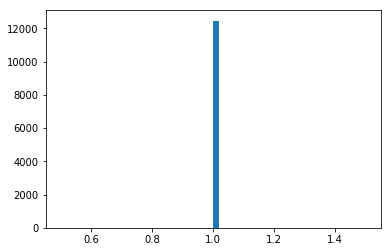

In [19]:
ds_ids, idCount = np.unique(currIDs, return_counts=True)
fig, (ax) = plt.subplots(1)
ax.hist(idCount,50)

In [20]:
# Set the length cutoff based on the histogram above.
length_cutoff = 600
nIds = np.size(ds_ids)
nClipped = np.size(np.where(idCount > length_cutoff))
nCurrIds = nIds - nClipped
print(nCurrIds)
coordMat = np.empty((nCurrIds,length_cutoff,2)) # 3rd dimension to represent the 2 geospatial coordinates


12454


The section below is pending validation in the original notebook...

In [21]:
i_id=0
trim_count=0
drop_count=0 # Dropped for having length of 1.
for nTraj in range(0,numIds):    # For each element of the big list
    tempID=trip_final["features"][nTraj]["properties"]["id_trip"] # This id from the list
    if sum(np.isin(currIDs,tempID))>0:    # If this ID is on our list
        if trip_final["features"][nTraj]["geometry"] is not None:    # And it is not an empty entry
            tempArray=[]
            tempArray=np.asarray(trip_final["features"][nTraj]["geometry"]["coordinates"][0][:]) # Load data as array instead of as a list.
            if tempArray.size > 2: # Use this to filter out single points
                curr_len = tempArray.size/2
                if(curr_len < length_cutoff):
                    temp_i = int(length_cutoff-curr_len) # To make sure they all end at the same time.
                    # May need further mods to tempArray to make it fit into the matrix as intended.
                    coordMat[int(i_id), temp_i:, :] = tempArray      # Add that slice vector to the coordMat array (to the end for visualization purposes)
                    i_id=i_id+1    
                else:
                      trim_count=trim_count+1
            else: 
                drop_count=drop_count+1

In [22]:
print(trim_count, drop_count)

132 0


## Visualize and export

Test to see that the operations properly limited our selection to the intended trajectories

In [23]:
# Set the values for all the plots here. I determined these to be the area of interest for this dataset.
xmin = -74
xmax = -73.4
ymin = 45.3
ymax = 45.8

[-74, -73.4, 45.3, 45.8]

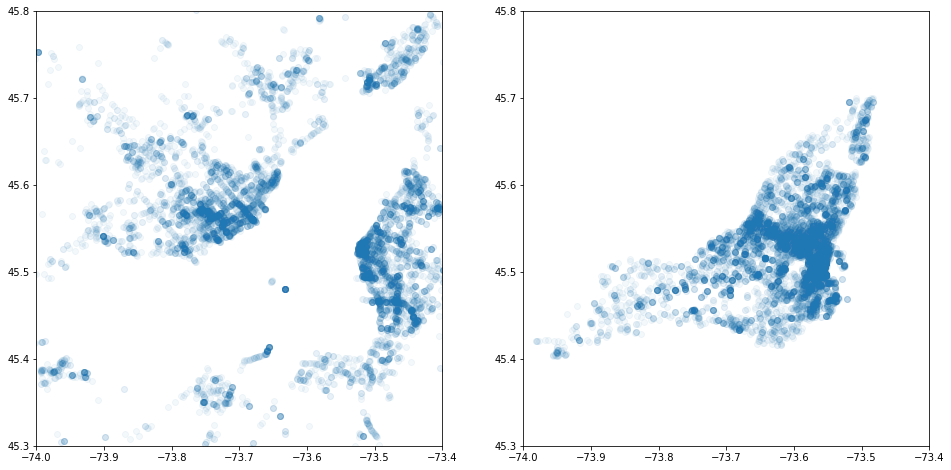

In [24]:
fig1, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(16, 8))
ax1.scatter(startPts[:,0],startPts[:,1], alpha=0.05)
ax1.axis([xmin, xmax, ymin, ymax]) # Setting the axes like this avoid the zero values in the preallocated empty array.

# fig1, (ax) = plt.subplots(1, figsize=(8, 8))
ax2.scatter(endPts[:,0],endPts[:,1], alpha=0.05)
ax2.axis([xmin, xmax, ymin, ymax]) # Setting the axes like this avoid the zero values in the preallocated empty array.

##### Start by making a static image inline to be sure the plot looks as intended:

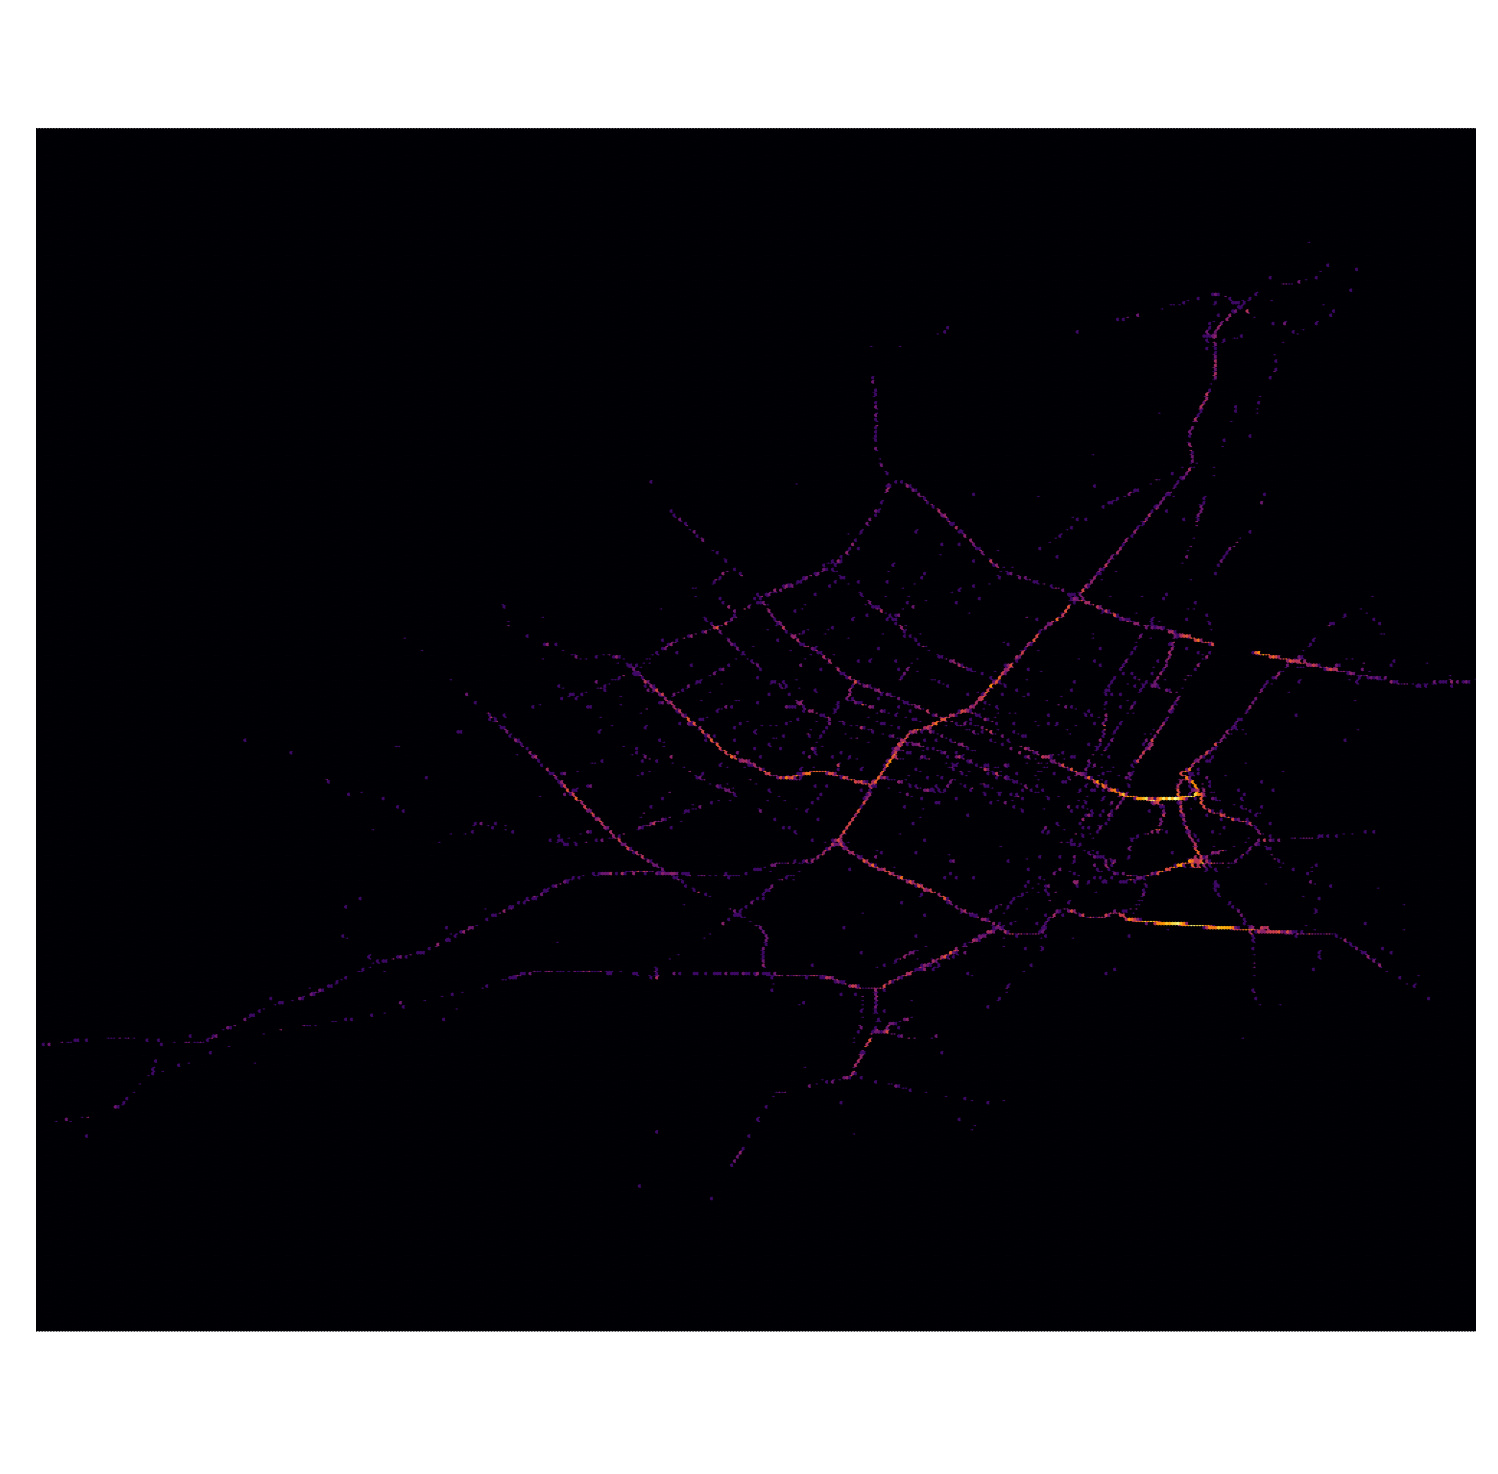

In [31]:
directory= '/output/'

if not os.path.exists(directory):
    os.makedirs(directory)

fig = plt.figure(frameon=False) 
fig.set_size_inches(20,20)

# To make the content fill the whole figure
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()

t=length_cutoff-100
x1=np.copy(np.squeeze(coordMat[:,t,0])) # With the above note in mind, this may be an exception??
y1=np.copy(np.squeeze(coordMat[:,t,1]))

# Remove the nans from the array
x1 = x1[~np.isnan(x1)]
y1 = y1[~np.isnan(y1)]

# Log colormap
hb = ax.hexbin(x1, y1, gridsize=500, bins='log', cmap='inferno',extent=(xmin, xmax, ymin, ymax))

fig.add_axes(ax)
ax.axis('equal')
plt.axis('off')
ax.axis([xmin, xmax, ymin, ymax]) # Setting the axes like this avoid the zero values in the preallocated empty array.

# save figure as png (check if all this is necessary)
png1 = BytesIO()
filename= directory+'testImage_'+ str(t) +'.png'
fig.savefig(filename, format='png', bbox_inches='tight', pad_inches=0)


##### Process the coordinate matrix 'coordMat' to create a timeseries.
Although it would be more elegant to export a gif directly, I haven't had this working to my satisfaction, so the code below exports a sequence of .png files that can be combined in another step or another program (I use Fiji)

C:\Users\tyler\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


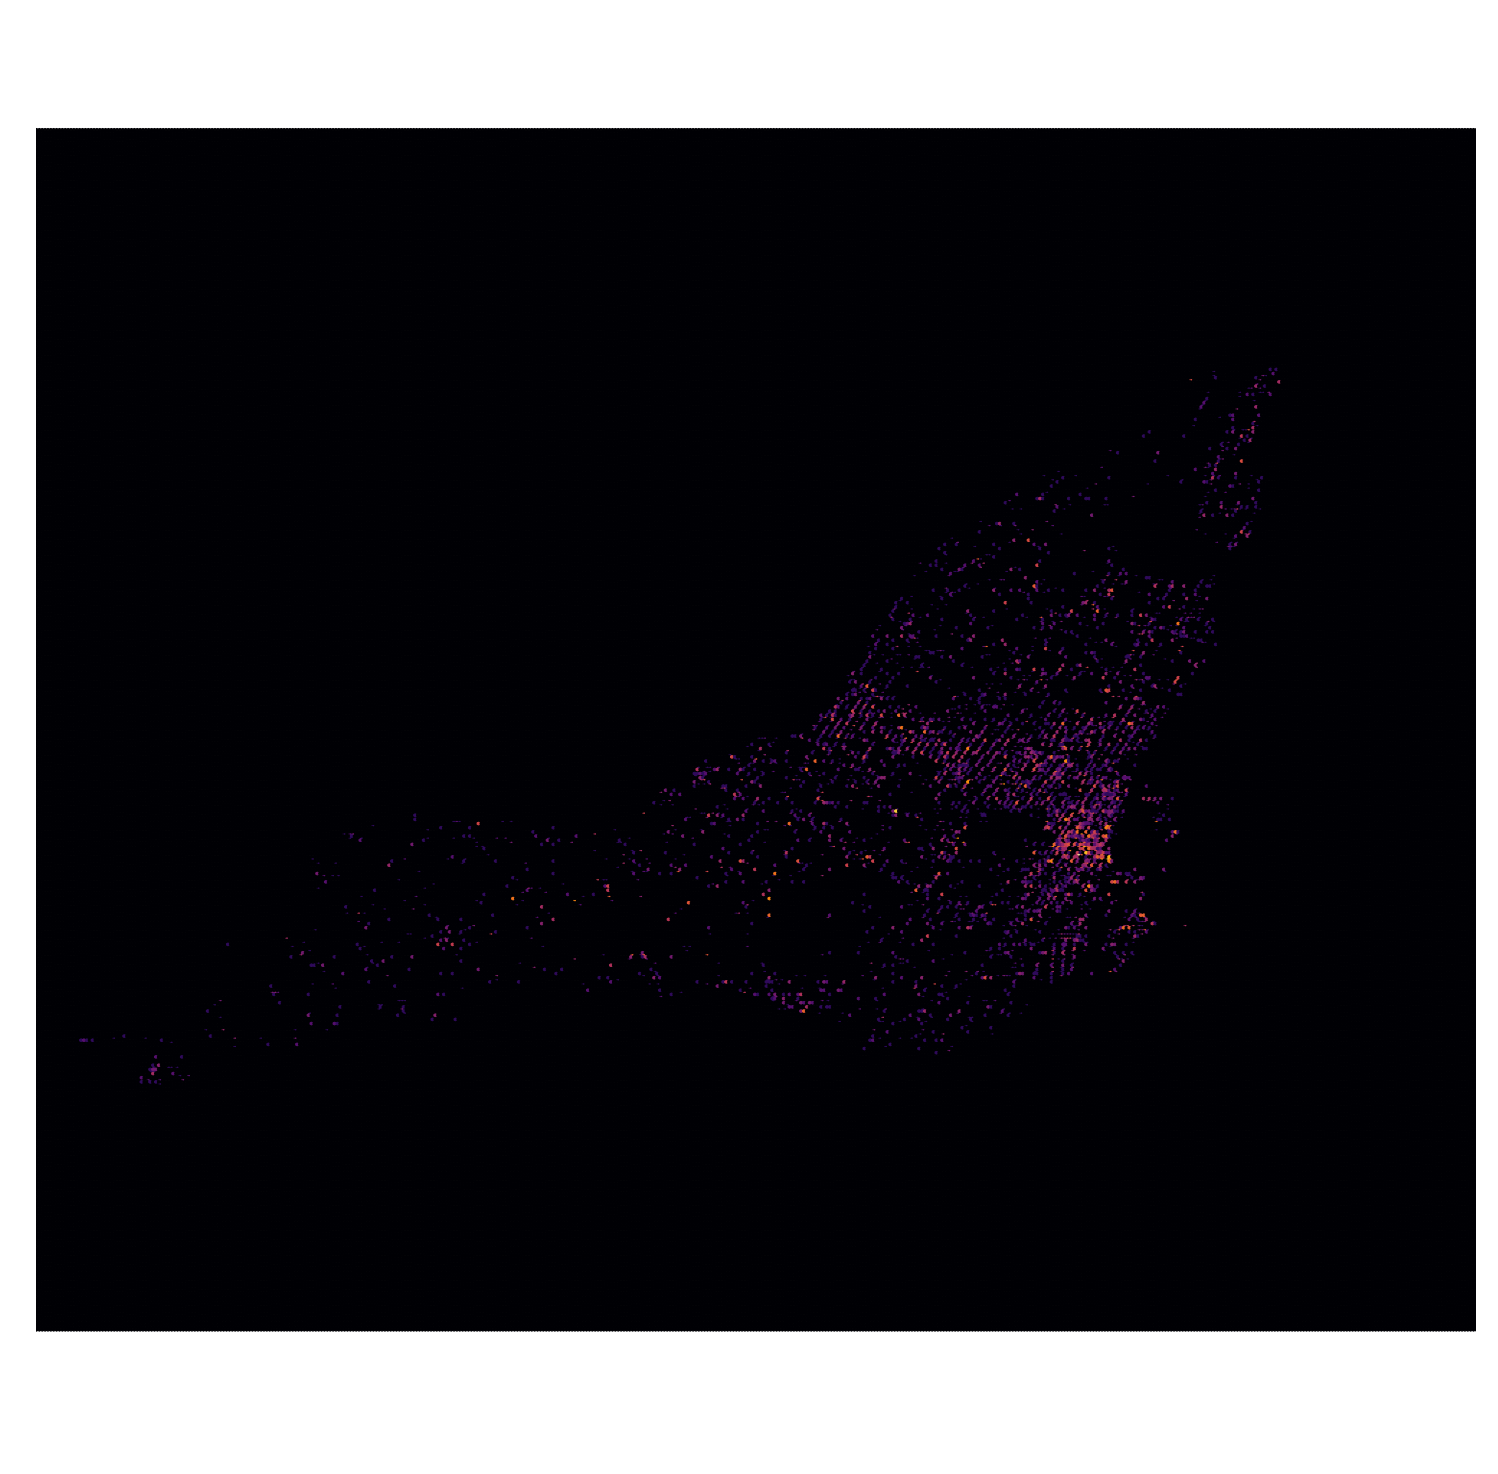

In [32]:
directory= '/output/'

fig = plt.figure(frameon=False) 
fig.set_size_inches(20,20)

# To make the content fill the whole figure
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()

for t in range(0,length_cutoff):
    ax.clear()
    x1=np.copy(np.squeeze(coordMat[:,t,0])) # With the above note in mind, this may be an exception??
    y1=np.copy(np.squeeze(coordMat[:,t,1]))

    # Remove the nans from the array
    x1 = x1[~np.isnan(x1)]
    y1 = y1[~np.isnan(y1)]

    # Log colormap
    hb = ax.hexbin(x1, y1, gridsize=500, bins='log', cmap='inferno',extent=(xmin, xmax, ymin, ymax))
    
    fig.add_axes(ax)
    ax.axis('equal')
    plt.axis('off')
    ax.axis([xmin, xmax, ymin, ymax]) # Setting the axes like this avoid the zero values in the preallocated empty array.

    # save figure as png (check if all this is necessary)
    png1 = BytesIO()
    filename= directory+'hexbin_trip_final_'+ str(t) +'.png'
    fig.savefig(filename, format='png', bbox_inches='tight', pad_inches=0)
 
    
